In [1]:
# import librarires
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pickle
import os
from custom_dataset import CustomDataset

In [ ]:
def get_directories(path):
    # Get list of all files and directories in the given path
    contents = os.listdir(path)
    
    # Filter out only directories
    directories = [content for content in contents if os.path.isdir(os.path.join(path, content))]
    
    return directories

In [ ]:
CATEGORIES = get_directories('./train')

In [2]:
train_data = pickle.load(open('./train_data.pickle', 'rb'))
val_data = pickle.load(open('./val_data.pickle', 'rb'))

In [3]:
new_train_data = CustomDataset(train_data)
new_val_data = CustomDataset(val_data)

In [5]:
# creating data loaders
loaders = {
    'train' : torch.utils.data.DataLoader(new_train_data, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(new_val_data, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fce70691430>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fce70691c10>}

In [6]:
# design cnn architecture / load pree-trained model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        '''
        Goes through two layers of 2D convolutions, each followed by a 2x2 max pooling
        
        Dimensions:
        1.) Input Shape:          [batch_size, 3, 256, 256]
        
        2.) After conv:           [batch_size, 6, 254, 254]
            After max pooling:    [batch_size, 6, 127, 127]
        
        3.) After conv:           [batch_size, 12, 125, 125]
            After max pooling:    [batch_size, 12, 62, 62]
            
        4.) After flattening:     [batch_size, 12 * 62 * 62]
        '''
        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=6,            
                kernel_size=3,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(6, 12, 3, 1, 0),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(12 * 62 * 62, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 16 * 8 * 8)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [7]:
cnn= CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=46128, out_features=10, bias=True)
)


In [8]:
loss_func = nn.CrossEntropyLoss(); print(loss_func)   
optimizer = torch.optim.Adam(cnn.parameters(), lr= 1e-4); print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [9]:
# validate
def validate(cnn, loader):
    cnn.eval()
        
    # evaluate the model
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for images, labels in loaders['test']:
            images = images.float() / 255.0  # Normalize images
            labels = labels.long()  # Convert labels to the appropriate data type
            
            outputs, _ = cnn(images)
            loss = loss_func(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = correct / total
    val_loss = total_loss / len(loader)
    return val_accuracy, val_loss

In [10]:
# train
def train(num_epochs, cnn, loaders):
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
    print("INITIATING TRAINING...")
    for epoch in range(num_epochs):
        acc_array = []
        loss_array = []
        for i, (images, labels) in enumerate(loaders['train']):
            # convert images and labels into float tensors and normalize
            images = images.float() / 255.0
            labels = labels.long()
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # measure accuracy and record loss
            train_output, last_layer = cnn(images)
            pred_y = torch.max(train_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            

            # clear gradients for this training step   
            optimizer.zero_grad()
            
            # backpropagation, compute gradients 
            loss.backward()
            
            # apply gradients             
            optimizer.step()  
            
            # validate model
            val_accuracy, val_loss = validate(cnn, loaders['test'])
            
            # storing results
            train_acc_data.append(accuracy)
            loss_data.append(loss.item())
            val_acc_data.append(val_accuracy)
            val_loss_data.append(val_loss)
            epochs_arr.append((i+1) / total_step)
            
            if (i+1) % 25 == 0 or (i+1) == total_step:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}, Validation Accuracy: {:.4f}, Validation Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), accuracy, val_accuracy, val_loss))
                
                
            
#             if (i+1) % 600 == 0:
#                 train_acc_data.append(accuracy)
#                 loss_data.append(loss)
            pass
        
        pass
    
    
    pass

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.figure(figsize=(12,7))
#     plt.savefig(path)
    plt.show()

In [11]:
# training and validating
num_epochs = 3
train_acc_data = []
loss_data = []
val_acc_data = []
val_loss_data = []
epochs_arr = []

train(num_epochs, cnn, loaders)

INITIATING TRAINING...
Epoch [1/3], Step [25/313], Loss: 1.6878, Accuracy: 0.3750, Validation Accuracy: 0.3240%
Epoch [1/3], Step [50/313], Loss: 1.7895, Accuracy: 0.3750, Validation Accuracy: 0.3460%
Epoch [1/3], Step [75/313], Loss: 1.4959, Accuracy: 0.5625, Validation Accuracy: 0.4150%
Epoch [1/3], Step [100/313], Loss: 1.4548, Accuracy: 0.5000, Validation Accuracy: 0.5170%
Epoch [1/3], Step [125/313], Loss: 1.4132, Accuracy: 0.7188, Validation Accuracy: 0.6110%
Epoch [1/3], Step [150/313], Loss: 1.3109, Accuracy: 0.5312, Validation Accuracy: 0.5680%
Epoch [1/3], Step [175/313], Loss: 1.3049, Accuracy: 0.7188, Validation Accuracy: 0.6350%
Epoch [1/3], Step [200/313], Loss: 0.7717, Accuracy: 0.9062, Validation Accuracy: 0.6360%
Epoch [1/3], Step [225/313], Loss: 1.0118, Accuracy: 0.7188, Validation Accuracy: 0.5970%
Epoch [1/3], Step [250/313], Loss: 0.9142, Accuracy: 0.7188, Validation Accuracy: 0.6660%
Epoch [1/3], Step [275/313], Loss: 0.7649, Accuracy: 0.8438, Validation Accuracy

/var/folders/rj/gwmtr5qj72g1yp53gy3xhz9m0000gn/T/ipykernel_17240/887425931.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x500 with 0 Axes>

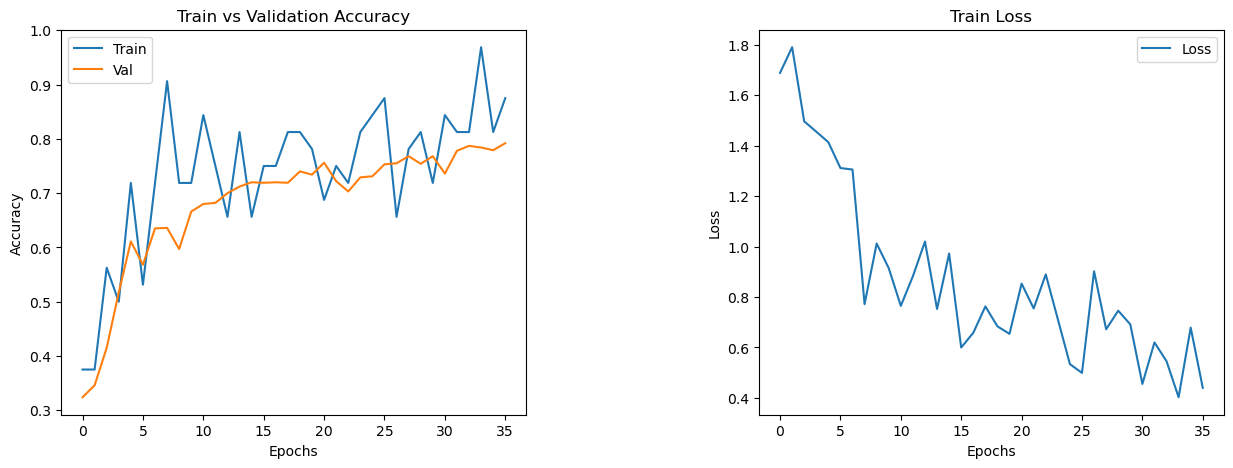

In [38]:
# performance analysis (loss, accuracy, cm)
plt.figure(figsize=(10,5))
fig, axs = plt.subplots(1,2, figsize=(15, 5), gridspec_kw={'wspace': 0.5})

axs[0].plot(train_acc_data, label='Train')
axs[0].plot(val_acc_data, label='Val')
axs[0].set_title('Train vs Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()


axs[1].plot(loss_data, label='Train Loss')
axs[1].plot(val_loss_data, label='Val Loss')
axs[1].set_title('Train Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
plot_confusion_matrix()